In [1]:
# Essentials
import pickle
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

# PyTorch
import torch
import torchvision
import torch.nn as nn  
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch.utils.data import DataLoader

In [ ]:
torch.__version__

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 1. Plotting histogram of materials

In [ ]:
# Imagenet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),  
        transforms.RandomHorizontalFlip(),  # augmentations
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

## Import resources

In [ ]:
# Directories
data_dir = "/storage/intern"
label_path = "./mat/MatLB3"
params_path = "./model/model_params"

In [ ]:
# Define parameter
batch_size = 8
num_workers = 2
experiment = "mat"
# Load Data
train_set = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_size = len(train_set)
val_size = len(val_set)
class_names = train_set.classes
num_class = len(class_names)
num_batches = math.floor(train_size/batch_size)
print(f"Number of classes: {num_class}")
print(f"Number of batches: {num_batches}")
print(class_names)

In [ ]:
# Model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
in_fc = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(in_fc, num_class)
# Load params
model.load_state_dict(torch.load(params_path))
model.eval()
# Labels
label_names = pickle.loads(open(label_path, "rb").read())

In [3]:
# Dataframe of file path and material
img_path = '/storage/gcpproddata/'
meta_path = '/storage/experiments/matpatclassify/csv/'
df = pd.read_csv(meta_path + 'imagepaths.csv')                      # path-bag-location dataset
df = df[df.location == 1]                                           # only need data with location 1
df1 = df[['path','bag']]                                            # remove location column
df2 = pd.read_csv(meta_path + 'bagsgucci.csv')[['bag', 'mat']]      # Bag-mat dataset
meta_df = df1.merge(df2, how='left', on='bag').drop('bag', axis=1)  # Merge on 2 dataset
meta_df = meta_df.replace(r'^\s*$', np.NaN, regex=True)             # Replace all empty string by NULL
meta_df = meta_df.dropna(axis=0)
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63615 entries, 337 to 69477
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    63615 non-null  object
 1   mat     63615 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [4]:
# Take a quick look at class distribution
label_df = meta_df["mat"]
freq = label_df.value_counts(normalize=True)
freq = round(freq, 4) * 100     # convert to percentage
print(freq)    

leather                           30.60
gg supreme canvas                 18.81
canvas                            17.87
ggcanvas                           9.53
guccissima                         4.24
                                  ...  
ｽｴｰﾄﾞ+ﾚｻﾞ-                         0.03
GGｴﾝﾎﾞｽﾚｻﾞｰ　                       0.03
ﾄﾞﾅﾙﾄﾞﾀﾞｯｸﾞﾌﾟﾘﾝﾄGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ     0.02
ﾌﾛｰﾗﾙﾌﾟﾘﾝﾄﾚｻﾞｰ                     0.02
ﾋﾞｰｽﾞ                              0.02
Name: mat, Length: 87, dtype: float64


## Pick top-20 class for visualization

In [5]:
robust_freq = pd.DataFrame(freq).iloc[:20]

## Histogram

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65414 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65420 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65432 missing from current font.
  font.set_

<Figure size 1152x1008 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65414 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65420 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65432 missing from current font.
  font.set_text(s, 0,

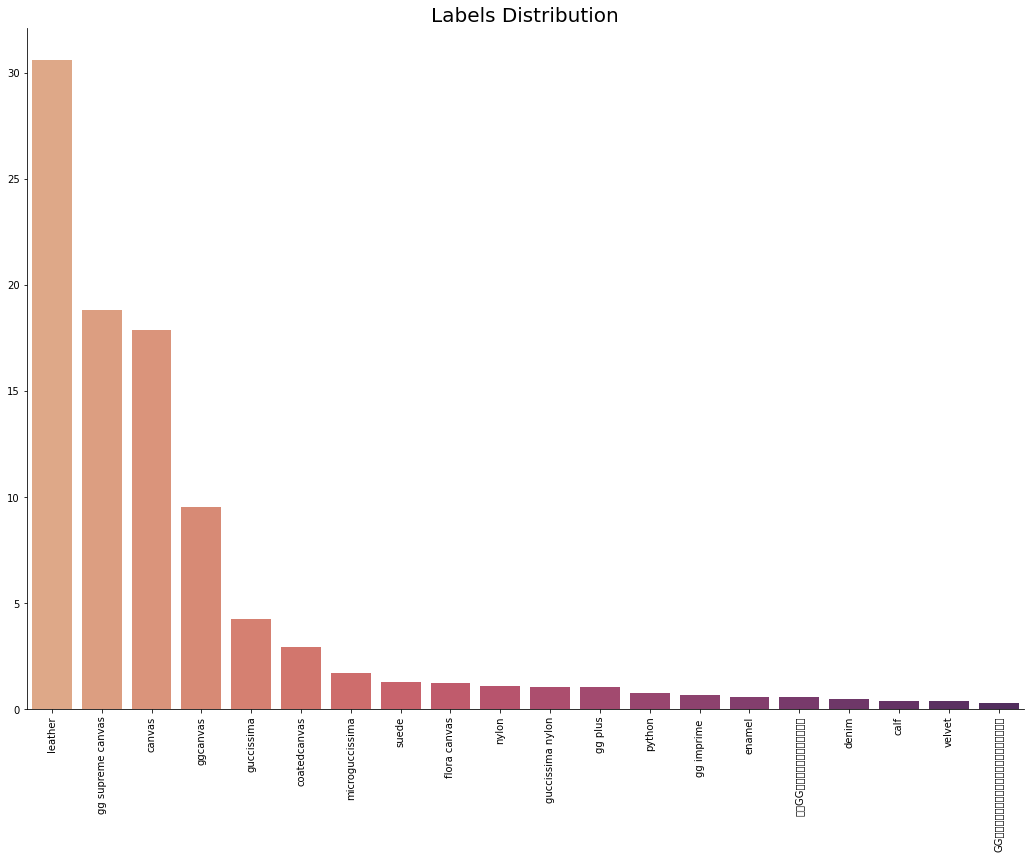

In [6]:
# Histogram with robust frequency labels
robust_freq = robust_freq.transpose()   # transpose for visualization

plt.figure(figsize=(16, 14))
sns.catplot(data=robust_freq, kind="bar", height=10, aspect=1.5, legend_out=True, palette="flare")
plt.xticks(rotation=90)
plt.title('Labels Distribution', fontsize=20)
# plt.savefig('LabelDist.png')
plt.show()

# 2. Plot a confusion matrix for materials.

## For first time

In [5]:
# Predict probability
prob = model.predict(val_set)

# Predict labels
y_pred = np.argmax(prob, axis = 1)
print(len(y_pred))  # 63615

# True labels
y_true = np.concatenate([y for x, y in val_set], axis=0)    # True label
print(len(y_true))  # 63615
# it take total around 90min

12504
12504


In [25]:
pred_path = "./mat/pred"
true_path = "./mat/true"
prob_path = "./mat/prob"

In [26]:
# Pickle label and prediction
f = open(pred_path, "wb")
f.write(pickle.dumps(y_pred))
f.close()

f = open(true_path, "wb")
f.write(pickle.dumps(y_true))
f.close()

f = open(prob_path, "wb")
f.write(pickle.dumps(prob))
f.close()

## Reimport probability, predict and true labels

In [9]:
# y_pred = pickle.loads(open(pred_path, "rb").read())
# y_true = pickle.loads(open(true_path, "rb").read())
# prob = pickle.loads(open(prob_path, "rb").read())

## Confusion matrix:

Confusion Matrix with Normalized

In [6]:
# Function for lower triangle confusion matrix
def tril_confusion_matrix(y_true, y_pred, normalize = None):
    """Create a lower triangle confusion matrix

    Args:
        y_true (NumpyArray): true labels
        y_pred (NumpyArray): prediction labels
        normalize ("true", "pred", "all", None optional): Choose whether normalize or not. Defaults to None.
    """
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    # Create an mask for triangle
    mask = np.ones_like(cm, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = False

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(16, 14))
    ax = plt.subplot()

    sns.heatmap(cm, ax=ax, mask=mask, cmap="Blues", square=True, linewidths=.5)

    ax.set_xlabel('Predicted Label', fontsize=20)
    ax.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)
    plt.title('Lower Triangle Confusion Matrix', fontsize=20)
    # plt.savefig('ConfusionMat.png')
    plt.show()

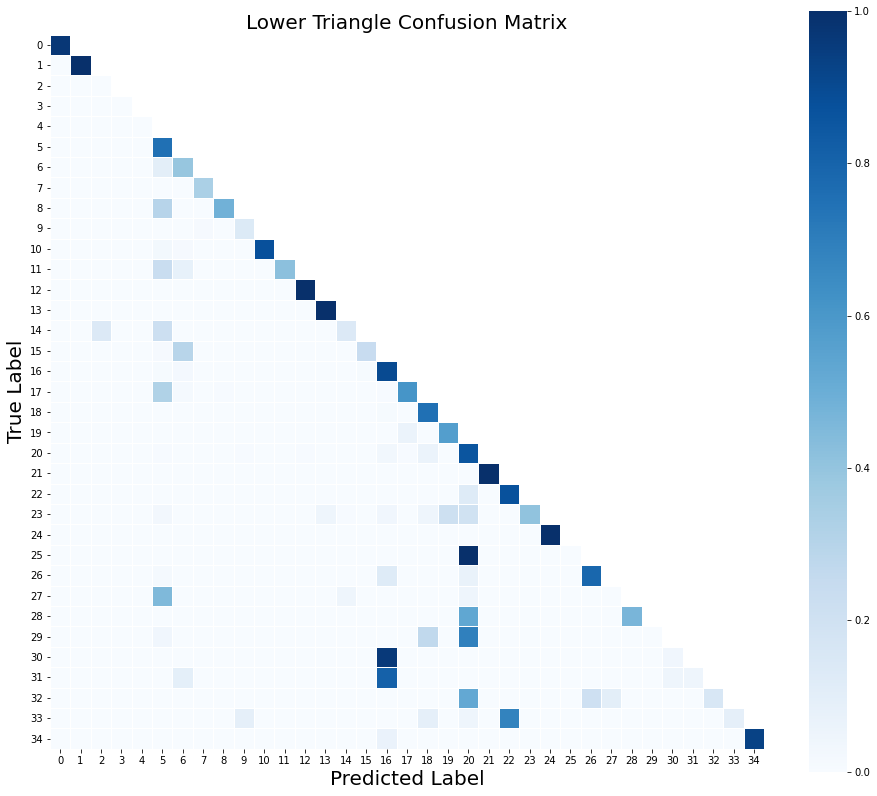

In [7]:
tril_confusion_matrix(y_true, y_pred, normalize="true")

Confusion matrix without Normalized

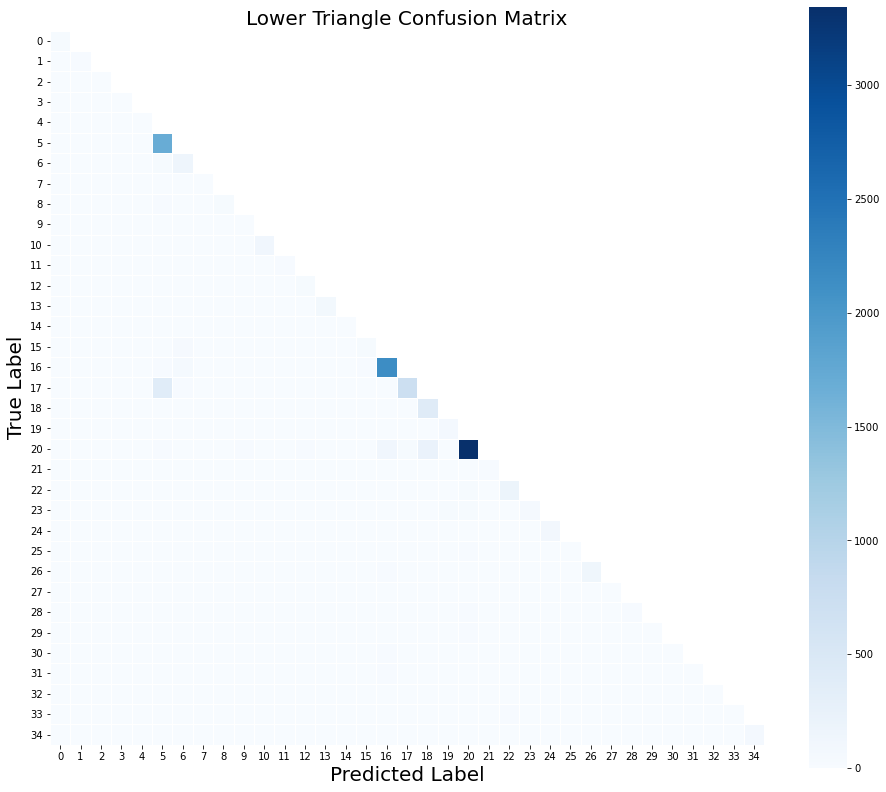

In [8]:
tril_confusion_matrix(y_true, y_pred)

In [13]:
a = [16, 30, 31]
for num in a:
    print(label_names[num])

gg supreme canvas
ｽﾀｰﾌﾟﾘﾝﾄGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ
ｽﾈｰｸﾌﾟﾘﾝﾄGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ


# 3. Take a look at results again

## The rate of wrong labeling in batch

In [31]:
wrong_idx = y_pred != y_true
print(f"Rate of wrong label: {round(wrong_idx.sum() / len(wrong_idx)*100, 2)}%")

Rate of wrong label: 1.63%


## The TODO: Visualize the worst errors

In [9]:
def find_the_worst_error(prob, y_pred, y_true, label_names, data_ds, batch_size):
    """Input numpy array with probability, prediction labels, true labels, dataset, batch size.
    Which return the worst prediction picture, predict and label

    Args:
        prob (ndarray): probability after prediction
        y_pred (numpy.parray): prediction label of dataset
        y_true (numpy.array): true label of dataset
        data_ds (tf.dataset): dataset
        batch_size (int): batch size of dataset
        label_names (list): list of labels class name

    Returns:
        _type_: _description_
    """
    
    # Find index
    mask = y_pred != y_true
    subset_idx = np.argmax(prob[mask]) // len(label_names)      # find the max probability with mask
    parent_idx = np.arange(prob.shape[0])[mask][subset_idx]     # find index in parent dataset
    batch_idx = parent_idx // batch_size                        # find batch
    idx = parent_idx % batch_size                               # find index in batch
    
    # Variable return
    label = label_names[y_true[parent_idx]]                     # label of the worst error
    worst_prob = max(prob[mask].flatten())
    predict = label_names[y_pred[parent_idx]]                   # prediction of the worst error
    batch = list(data_ds.skip(batch_idx).take(1))[0][0].numpy() # remove the label
    picture = batch[idx]
    
    # Print result
    plt.imshow(picture.astype(np.uint8))
    plt.axis("off")
    print(f"The prediction label is: {predict}")
    print(f"The true label is: {label}")
    print(f"The probability is {worst_prob * 100}%")
    # return picture, worst_pred, label

The prediction label is: microguccissima
The true label is: guccissima
The probability is 100.0%


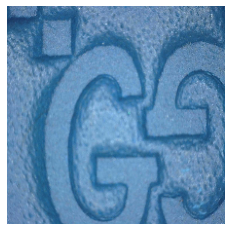

In [10]:
find_the_worst_error(prob=prob, 
                     y_pred=y_pred, 
                     y_true=y_true, 
                     label_names=label_names, 
                     data_ds=val_set, 
                     batch_size=batch_size)